# Walk-Forward Validation with StatsModel

When using models from StatsModel API, you need to apply the cross-validation technique manually, rather than using another API like SciKit-Learn. Using the airline passengers dataset, you will 'walk-forward' through the training set, validating each iteration with Holt-Winters model.

The 'walk-forward' technique applies a technique similar to K-Folds cross-validation, by splitting the dataset into the minimum training set size and implementing a specified number of timesteps to add from the test set for each iteration, 
i.e. you start with an initial training set size and add a certain amount of sequential timesteps from the test set with each iteration until the end of the dataset. So you do not specify the number of 'folds', you specify the initial size of the training set and the number of steps to 'walk forward'.

The final result is the average of the errors (MSE) calculated from each iteration, for a more realistic assessment of model performance.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# Useful for looping through parameter combinations
import itertools

%matplotlib inline

In [2]:
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.holtwinters import ExponentialSmoothing

In [3]:
df = pd.read_csv('data/airline_passengers.csv', index_col='Month', parse_dates=True)

In [4]:
# Timeline frequency set to start-of-every-month

df.index.freq = 'MS'

In [5]:
# 12 years of data

df.shape

(144, 1)

In [6]:
df.head()

,Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


In [7]:
# Forecast horizon is 12 steps
h = 12

# No of 'walk-forward' steps
steps = 10

# Validation period - min size of training set
N_test = len(df) - h - steps + 1

In [8]:
N_test

123

**After defining the parameters for cross-validation (above), you can also set up the machine-learning model (`ExponentialSmoothing()`) parameters as variables that contain possible configuration options to try during cross-validation, like a grid search.**

**NOTE: StatsModel documentation is incorrect for `use_boxcox` parameter - you cannot use 'log' as an option, only `True`, `False` for box-cox transformation, or `0` as possible value for lambda. Since you are transforming the values to log format, then lambda equal to zero is also acceptable.**

In [9]:
trend_type_list = ['add', 'mul']
seasonal_type_list = ['add', 'mul']
damped_trend_list = [True, False]
init_method_list = ['estimated', 'heuristic', 'legacy-heuristic']
use_boxcox_list = [True, False, 0]

## Walk-Forward function

**The code to 'walk-forward' through the validation set can be implemented with a custom function that accepts a possible parameter option and a final flag in case you want to debug.**

**Inside the function, the errors (SciKit-Learn MSE) from each iteration are stored in an errors variable so that the function can output the mean of the errors. If debugging, the function will also return a flag indicating whether the code as looped upto the final row in the dataset. There is an additional output to confirm the number of steps completed during the last walk-forward, i.e. 10.**

In [10]:
def walkforward(trend_type, seasonal_type, damped_trend, init_method, use_boxcox, debug=False):
    # Store errors 
    errors = [] 
    # All rows processed?
    seen_last = False 
    # No of steps completed (should be 10)
    steps_completed = 0
    
    for end_of_train in range(N_test, len(df) - h + 1):
        # No need to manually 'add' data to dataset, just index it at the right points - it is a "view" not a "copy" 
        # (so it doesn't take up any extra space or computation) 
        train = df.iloc[:end_of_train] 
        test = df.iloc[end_of_train:end_of_train + h] 
        
        # For debugging
        if test.index[-1] == df.index[-1]:
            seen_last = True
        
        # Increment walk-forward by 1
        steps_completed += 1
        
        # Instantiate model
        hw = ExponentialSmoothing(train['Passengers'], 
                                  initialization_method=init_method, 
                                  trend=trend_type, 
                                  damped_trend=damped_trend,
                                  seasonal=seasonal_type,
                                  seasonal_periods=12,
                                  use_boxcox=use_boxcox) 
        
        # Train model
        res_hw = hw.fit()
        
        # Compute error for the forecast horizon 
        fcast = res_hw.forecast(h) 
        error = mean_squared_error(test['Passengers'], fcast) 
        errors.append(error)
    
    # Check debug flag
    if debug:
        print("seen_last:", seen_last) 
        print("steps completed:", steps_completed)
        
    return np.mean(errors)

In [11]:
# Test function

walkforward('add', 'add', False, 'legacy-heuristic', 0, debug=True)

seen_last: True
steps completed: 10


2521.0271721807176

**MSE value of 2521.03, which gives us RMSE of approx. 158.78**


## Grid search during cross-validation

**You can loop through every possible combination of the model parameters, similar to grid-search, with Python's `itertools` module.**

In [12]:
# Iterate through all possible parameter options (i.e. grid search)

tuple_of_option_lists = (trend_type_list, seasonal_type_list, damped_trend_list, init_method_list, use_boxcox_list)

# Print every possible combination of model parameters (72 combinations in total - I counted!)
for x in itertools.product(*tuple_of_option_lists):
    print(x)

('add', 'add', True, 'estimated', True)
('add', 'add', True, 'estimated', False)
('add', 'add', True, 'estimated', 0)
('add', 'add', True, 'heuristic', True)
('add', 'add', True, 'heuristic', False)
('add', 'add', True, 'heuristic', 0)
('add', 'add', True, 'legacy-heuristic', True)
('add', 'add', True, 'legacy-heuristic', False)
('add', 'add', True, 'legacy-heuristic', 0)
('add', 'add', False, 'estimated', True)
('add', 'add', False, 'estimated', False)
('add', 'add', False, 'estimated', 0)
('add', 'add', False, 'heuristic', True)
('add', 'add', False, 'heuristic', False)
('add', 'add', False, 'heuristic', 0)
('add', 'add', False, 'legacy-heuristic', True)
('add', 'add', False, 'legacy-heuristic', False)
('add', 'add', False, 'legacy-heuristic', 0)
('add', 'mul', True, 'estimated', True)
('add', 'mul', True, 'estimated', False)
('add', 'mul', True, 'estimated', 0)
('add', 'mul', True, 'heuristic', True)
('add', 'mul', True, 'heuristic', False)
('add', 'mul', True, 'heuristic', 0)
('add

**Apply the 'walk-forward' function to each combination of model parameters in a For Loop, storing each MSE score in a variable. The lowest score will lead you to the optimum configuration of model parameters.**

**In reality, you would not count or know the full list of possible combinations, therefore it should be treated as `*args` type for the `product()` function.**

In [13]:
# Some warnings about 'overflow' indicating a bad model that has been rejected

best_score = float('inf')
best_options = None

for x in itertools.product(*tuple_of_option_lists):
    score = walkforward(*x) 
    
    if score < best_score:
        print("Best score so far:", score) 
        best_score = score 
        best_options = x

Best score so far: 412.8173279532387
Best score so far: 412.7068263792439
Best score so far: 320.6641422055756


C:\Users\shmel\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
C:\Users\shmel\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
C:\Users\shmel\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
C:\Users\shmel\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
C:\Users\shmel\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
C:\Users\shmel\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
C:\Users\shmel\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:83: Runt

Best score so far: 305.65933493126124


C:\Users\shmel\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
C:\Users\shmel\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
C:\Users\shmel\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
C:\Users\shmel\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
C:\Users\shmel\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
C:\Users\shmel\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
C:\Users\shmel\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:83: Runt

Best score so far: 284.55236957354686


C:\Users\shmel\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
C:\Users\shmel\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
C:\Users\shmel\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
C:\Users\shmel\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
C:\Users\shmel\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
C:\Users\shmel\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
C:\Users\shmel\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:83: Runt

Best score so far: 268.62187164455725


C:\Users\shmel\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
C:\Users\shmel\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
C:\Users\shmel\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
C:\Users\shmel\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
C:\Users\shmel\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
C:\Users\shmel\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
C:\Users\shmel\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:83: Runt

In [14]:
print("Best score:", best_score)

Best score: 268.62187164455725


In [17]:
trend_type, seasonal_type, damped_trend, init_method, use_boxcox = best_options

print("Best model parameters:\n")
print("trend:", trend_type)
print("seasonal:", seasonal_type)
print("damped_trend:", damped_trend)
print("initialization_method:", init_method)
print("use_boxcox:", use_boxcox)

Best model parameters:

trend: mul
seasonal: mul
damped_trend: True
initialization_method: legacy-heuristic
use_boxcox: False


## Re-build model with optimum parameters

In [18]:
Ntest = 12

train = df.iloc[:-Ntest]
test = df.iloc[-Ntest:]

In [19]:
hw = ExponentialSmoothing(train['Passengers'], 
                          initialization_method='legacy-heuristic', 
                          trend='mul', 
                          damped_trend=True, 
                          seasonal='mul',
                          seasonal_periods=12,
                          use_boxcox=False)

res_hw = hw.fit()

C:\Users\shmel\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err


In [20]:
train_idx = df.index <= train.index[-1]
test_idx = df.index > train.index[-1]

In [21]:
df.loc[train_idx, 'train_preds'] = res_hw.fittedvalues
df.loc[test_idx, 'forecast'] = res_hw.forecast(Ntest)

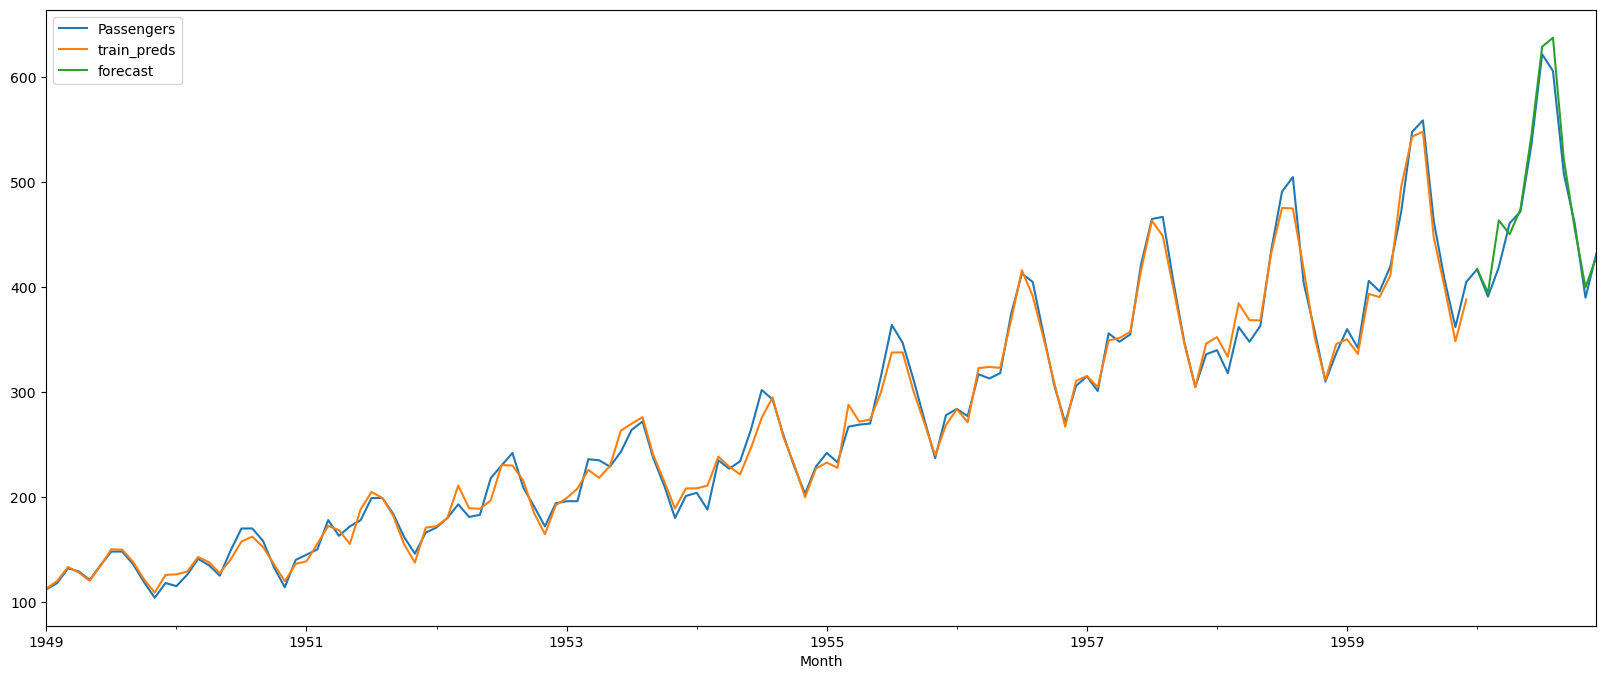

In [22]:
df[['Passengers', 'train_preds', 'forecast']].plot(figsize=(20, 8));

**The multiplicative trend and multiplicative seasonal patterns seem to fit the original time series quite well. Interestingly, we have True for the 'dampened trend', even though the trend does not seem to dampen over time (flatten out). If anything, the numbers appear more extreme over time. Additionally, we have False for box-cox transforms meaning we got the best results without scaling the original values.**